In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler



Check for infinite values in the dataset:
Year          0
quarter       0
passengers    0
fare          0
dtype: int64
Data shape after outlier removal: (241198, 4)
Feature values:
tensor([[3.2258e-01, 6.6667e-01, 1.7709e-02],
        [3.8710e-01, 6.6667e-01, 9.8783e-03],
        [6.1290e-01, 3.3333e-01, 6.4811e-02],
        [5.8065e-01, 1.0000e+00, 9.6374e-04],
        [5.4839e-01, 1.0000e+00, 1.6263e-02]])
Target values:
tensor([[164.8400],
        [189.0200],
        [144.8200],
        [269.7200],
        [258.8300]])
Epoch [100/1000], Loss: 50200.8477
Epoch [200/1000], Loss: 50195.6055
Epoch [300/1000], Loss: 50190.3594
Epoch [400/1000], Loss: 50185.1172
Epoch [500/1000], Loss: 50179.8750
Epoch [600/1000], Loss: 50174.6367
Epoch [700/1000], Loss: 50169.3867
Epoch [800/1000], Loss: 50164.1484
Epoch [900/1000], Loss: 50158.9062
Epoch [1000/1000], Loss: 50153.6641
Predicted fare = 0.3317 * Year + -0.2622 * quarter + 0.4682 * passengers + -0.0600


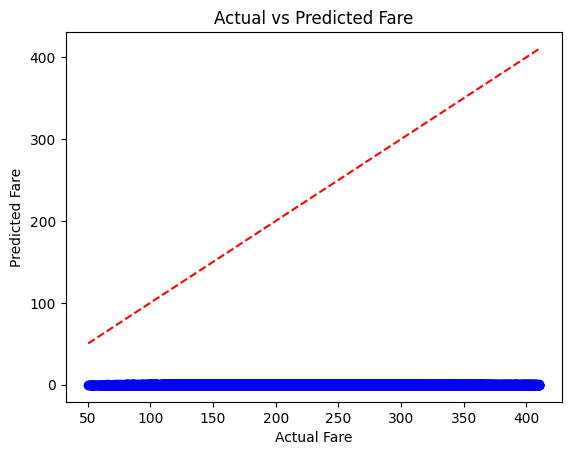

In [63]:


# Load the data from the pickle file
data = pd.read_pickle('df_pickle.pkl')

# Remove rows with NaN values in relevant fields
data = data[['Year', 'quarter', 'passengers', 'fare']].dropna()

# Convert boolean values in 'quarter' to integers (True = 1, False = 0)
data['quarter'] = data['quarter'].astype(int)

# Check for infinite values in the dataset
print("Check for infinite values in the dataset:")
print(data.isin([float('inf'), -float('inf')]).sum())

# Remove outliers using IQR (Interquartile Range)
Q1 = data['fare'].quantile(0.25)
Q3 = data['fare'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the data to remove outliers
data = data[(data['fare'] >= lower_bound) & (data['fare'] <= upper_bound)]

# Ensure data types are correct
data['Year'] = data['Year'].astype(float)
data['quarter'] = data['quarter'].astype(float)
data['passengers'] = data['passengers'].astype(float)
data['fare'] = data['fare'].astype(float)

# Normalize the features
scaler = MinMaxScaler()
data[['Year', 'quarter', 'passengers']] = scaler.fit_transform(data[['Year', 'quarter', 'passengers']])

# Check the shape of the data after outlier removal
print(f"Data shape after outlier removal: {data.shape}")

# Select relevant features and target
features = data[['Year', 'quarter', 'passengers']]
target = data['fare']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Check input values before training
print("Feature values:")
print(X_train_tensor[:5])  # Display the first 5 rows of training features
print("Target values:")
print(y_train_tensor[:5])   # Display the first 5 target values

# Define the model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(3, 1)  # 3 input features

    def forward(self, x):
        return self.linear(x)

# Instantiate the model, define loss function and optimizer
model = LinearRegressionModel()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)  # Lowered learning rate

# Train the model
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Check for NaN in outputs or loss
    if torch.isnan(outputs).any() or torch.isnan(loss):
        print("NaN detected in outputs or loss")
        break
    
    # Backward pass and optimization
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Get model parameters
with torch.no_grad():
    w = model.linear.weight[0].numpy()
    b = model.linear.bias.item()

# Print the equation of the model
print(f'Predicted fare = {w[0]:.4f} * Year + {w[1]:.4f} * quarter + {w[2]:.4f} * passengers + {b:.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.numpy()

# Scatter plot of actual vs predicted fare
plt.scatter(y_test, y_pred, color='blue')
plt.xlabel('Actual Fare')
plt.ylabel('Predicted Fare')
plt.title('Actual vs Predicted Fare')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')  # Line y=x
plt.show()


In [64]:
# Calculate predictions and errors
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.numpy()

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)

# Calculate Standard Deviation of actual fares
std_dev = np.std(y_test)

# Print metrics
print(f'Standard Deviation of Actual Fares: {std_dev:.4f}')
print(f'R-squared: {r_squared:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')

Standard Deviation of Actual Fares: 69.2303
R-squared: -9.5546
Mean Absolute Error: 213.9992
